
## Assessing Climate Change Impacts on a Pair of Symbiotic Species with Ensemble Species Distribution Models: *Xantusia vigilis*

*What underlying uncertainties are contained in geospatial climate change forecasts? How can models of climate change effects on geographic distributions incorporate symbiotic species relationships?*

---

Author : [Daniel Furman](mailto:dryanfurman@gmail.com) **|** Harvey Mudd College **|** NSF Award (#1757952) **|** [Online Render of Notebook](https://nbviewer.jupyter.org/github/daniel-furman/ensemble-climate-projections/blob/main/Comparing_MLs.ipynb)

---

Scripts for reproducing analyses presented at SICB 2021 and [SCCUR 2019](https://drive.google.com/file/d/114wmqQgjkc5DHLQmVI19AvlTw4K_daYQ/view?usp=sharing) conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Part 1: Introduction to Study
---

* `Fundamental niche:` The entire envelope of abiotic and biotic factors suitable to the survival of a species
* `Species Distribution Models (SDMs):` Associates presence locations to environmental variables, an estimate of fundamental niche
* `Symbiotic species:` A close and long-term biological interaction between two species, e.g. the Desert Night Lizard (*X. vigilis*) is often reliant on Joshua Trees (*Y. brevifolia*) for shelter
* `Workflow:` Data pre-processing -> Model fitting -> Assessment -> Baseline interpolation (1970-2000) -> Extrapolation across 21st century

**Question 1: *What underlying uncertainties are contained in geospatial climate change forecasts?*** An ensemble of SDMs were extrapolated to unseen data, across eight Global Climate Models (GCMs), four shared socioeconomic pathways, and three bi-decade time periods. Across these future climate forecasts, we predicted the same magnitude of habitat degradation for the two study species (49% to 90.7% Night Lizard decline from baseline; 52% to 91.4% Joshua Tree decline from baseline). We consider the mean statistic, for the figure below, where at least five out of eight GCMs agreed, assuming negligible species dispersal from the baseline distribution (area of intersection / area of baseline).

<img src="data/ensemble_extrapolation.png" width = 630/>

**Question 2: *How can models of climate change effects on geographic distributions best incorporate symbiotic species relationships?*** We minimized modelling error by using a soft voting ensemble of well-fit classifiers, as well as by benchmarking climatic change between interpolation and extrapolation data, with Jaccard Similarity among principal components. While the magnitude of habitat decline was roughly equivalent (see above), the two species distributions were predicted to diverge across the 21st century, with substanital decline in spatial overlap (~56% decrease from current conditions, on average). By 2090, overlap between the two distributions may decrease by as much as ~87% from current conditions. 

**Conclusion:** Our results reveal the importance of symbiotic species relationships for SDMs, so to more confidently select areas within predictions of truly suitable habitat. We hypothesize that habitat degradation for our two study species will be heightened where severely changing climate is paired with environmental catastrophe, such as strong wildfire. In conclusion, we pinpoint areas across the region where conservation for the two species should be targeted.

### Part 2: Constructing Soft Voting Machine Learning Ensemble
---

In [83]:
# train classifiers for species distribution models via 10-fold CV
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8464,0.9232,0.8465,0.8486,0.8461,0.6928,0.6950,0.2940
lightgbm,Light Gradient Boosting Machine,0.8376,0.9166,0.8376,0.8411,0.8371,0.6752,0.6787,0.0680
catboost,CatBoost Classifier,0.8366,0.9192,0.8366,0.8399,0.8361,0.6732,0.6765,2.2940
rf,Random Forest Classifier,0.8356,0.9210,0.8357,0.8392,0.8351,0.6712,0.6748,0.3580
xgboost,Extreme Gradient Boosting,0.8346,0.9120,0.8347,0.8384,0.8341,0.6692,0.6730,0.1920
gbc,Gradient Boosting Classifier,0.8227,0.9068,0.8227,0.8244,0.8225,0.6455,0.6472,0.1560
ada,Ada Boost Classifier,0.8189,0.8840,0.8190,0.8245,0.8181,0.6378,0.6434,0.0700
qda,Quadratic Discriminant Analysis,0.8060,0.8890,0.8062,0.8183,0.8041,0.6122,0.6243,0.0090
dt,Decision Tree Classifier,0.7923,0.7935,0.7922,0.7938,0.7920,0.5844,0.5860,0.0160
knn,K Neighbors Classifier,0.7875,0.8647,0.7876,0.7909,0.7868,0.5750,0.5784,0.0840


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the three most predictive PyCaret classifiers, based on the validation F statistic.

---

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation Random Forest : 0.8701657458563536
[[159  22]
 [ 25 156]]
The F1 validation score is :  0.8690807799442898


Fraction correct validation Catboost : 0.8729281767955801
[[156  25]
 [ 21 160]]
The F1 validation score is :  0.8743169398907105


Fraction correct validation LGBoost Machine : 0.8784530386740331
[[160  21]
 [ 23 158]]
The F1 validation score is :  0.8777777777777777


Fraction correct validation Extra Trees : 0.8729281767955801
[[155  26]
 [ 20 161]]
The F1 validation score is :  0.8749999999999999


Fraction correct validation XGBoost : 0.861878453038674
[[157  24]
 [ 26 155]

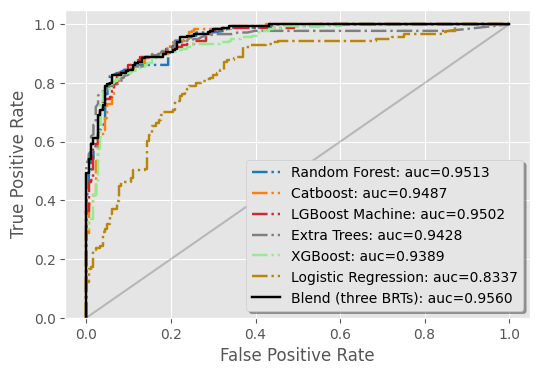

In [84]:
exec(open('ML_sdms_predict.py').read())

In [85]:
# blended (BRTs & RF) feature importance from the validation set
feature_importances[len(feature_importances)-1]
f_score

,LGBoost Machine,Blend (three BRTs),Extra Trees,Catboost,Random Forest,XGBoost,Logistic Regression
F-statistic :,0.877778,0.875346,0.875,0.874317,0.869081,0.861111,0.775401


### Part 3: Geospatial Predictions of Species Distributions

---

In [87]:
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute

In [89]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features, see Appendix section 1 below for feature selection methods
explanatory_rasters = ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18',
               'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8','bclim9']
i = 0
for f in explanatory_rasters:
    explanatory_rasters[i] = ('data/train-rasters-2.5m/' + f + '.asc')
    i = (i + 1)
print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab shapefile containing 100% of the final presence/absence locations
response_data = gpd.GeoDataFrame.from_file('data/geofile-xv-presences/xv.shp') 
response_data.head(10) # check geopandas data 


There are 12 .asc features.


,CLASS,geometry
0,1.0,POINT (-118.42197 35.77997)
1,0.0,POINT (-117.35417 35.27083)
2,1.0,POINT (-118.60656 34.78263)
3,0.0,POINT (-120.18750 37.35417)
4,1.0,POINT (-118.17866 34.87086)
5,1.0,POINT (-116.28900 36.38120)
6,0.0,POINT (-116.52083 34.77083)
7,1.0,POINT (-120.65644 36.51553)
8,1.0,POINT (-113.48183 34.47417)
9,1.0,POINT (-120.81202 36.59944)


In [90]:
print("number of duplicates: ", response_data.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", response_data['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(response_data.crs))
print("{} observations with {} columns".format(*response_data.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
1814 observations with 2 columns


In [91]:
# create pyimpute framework
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='CLASS') 
train_xs.shape, train_y.shape # check shape

((1814, 12), (1814,))

In [93]:
# spatial prediction with the 3-model blended classifier
from sklearn import model_selection
import os
session_number = 'exp_id=101, xantusia_after'

target_xs, raster_info = load_targets(explanatory_rasters)
k = 5 
kf = model_selection.KFold(n_splits=k)
accuracy_scores = model_selection.cross_val_score(blender_specific, train_xs, train_y, cv=kf, scoring='accuracy')
print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
#os.mkdir('outputs' + session_number)
#os.mkdir('outputs' + session_number + '/blender-baseline')
impute(target_xs, blender_specific, raster_info, outdir='outputs' + session_number + '/blender-baseline',
       class_prob=True, certainty=True)

Blend (three BRTs) 5-fold Cross Validation Accuracy: 86.88 (+/- 1.98)


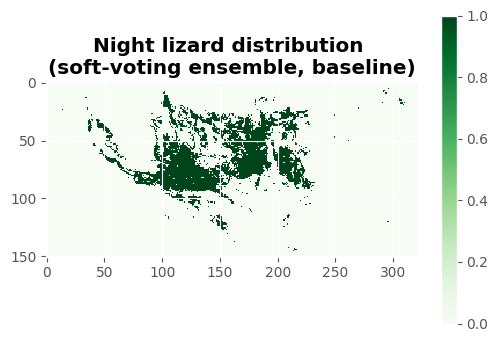

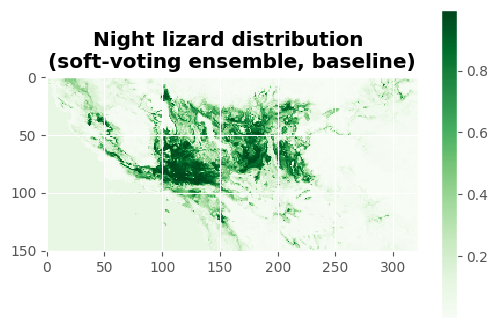

In [94]:
# plot the spatial output of the 3-model blended classifier
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
blended_curr = rasterio.open('outputs'+ session_number + '/blender-baseline/responses.tif')
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
        cmap='Greens')
plt.figure()
blended_curr = rasterio.open('outputs' + session_number + '/blender-baseline/probability_1.0.tif') 
plotit(blended_curr.read(1),'Night lizard distribution \n(soft-voting ensemble, baseline)',
       cmap='Greens')
print('')

### Part 4: Predicting Suitability Under Climate Change Scenarios
---
Part 4 is unable to re-run without additional data/scripts not contained in the Git repo, contact for further information.

In [95]:
# extrapolate model to 128 future scenarios
exec(open('future_projection.py').read())

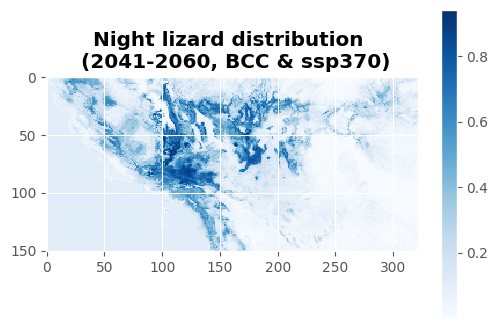

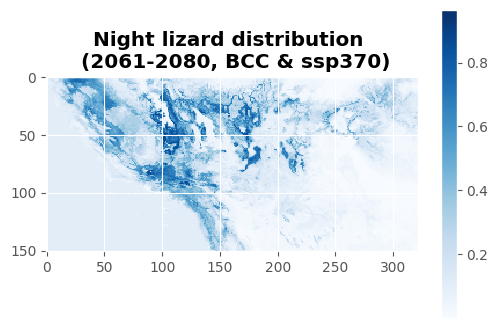

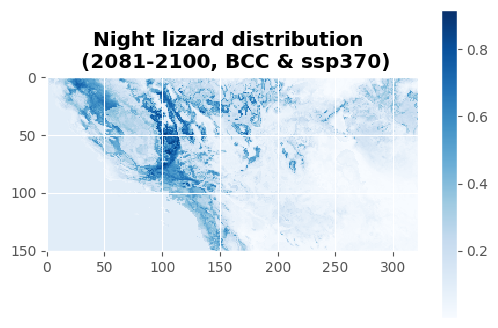

<Figure size 600x400 with 0 Axes>

In [96]:
for i in ['2041-2060','2061-2080','2081-2100']:
    future = rasterio.open('data/CMIP6/ssp370_' + i + '/BCC/probability_1.0.tif').read(1)
    plotit(future, 'Night lizard distribution \n ('+ i + ', BCC & ssp370)')
    plt.figure()

### Appendix 1: Removing Correlated Features
---

Recursively selects de-correlated features for modeling below a Spearman's threshold, using the rank of feature importance scores.

---

In [97]:
exec(open('recursive-ranker.py').read())

In [98]:
# load csv files for recursion function
covariance = pd.read_csv('data/collinearity/xv-baseline.csv')
feature_importance = pd.read_csv('maxent/maxent_19_variables_xv/maxent-jacknife.csv')
recursive_ranker(covariance, feature_importance, 0.85,
                 pd.read_csv('data/collinearity/raw_data.csv'))

Comparing bclim16 or bclim19  | Dropping bclim16
Comparing bclim13 or bclim19  | Dropping bclim13
Comparing bclim1 or bclim10  | Dropping bclim10
Comparing bclim14 or bclim17  | Dropping bclim17
Comparing bclim12 or bclim19  | Dropping bclim19
Comparing bclim1 or bclim5  | Dropping bclim5
Comparing bclim1 or bclim11  | Dropping bclim1

final set of variables:  ['bclim11', 'bclim12', 'bclim14', 'bclim15', 'bclim18', 'bclim2', 'bclim3', 'bclim4', 'bclim6', 'bclim7', 'bclim8', 'bclim9']

Covariance matrix (r <  0.85 ):

         bclim11   bclim12   bclim14   bclim15   bclim18    bclim2    bclim3  \
bclim11      1.0  0.360369  0.601673  0.153659  0.324422  0.154140  0.085145   
bclim12      0.0  1.000000  0.185364  0.517731  0.101761  0.309390  0.352861   
bclim14      0.0  0.000000  1.000000  0.632534  0.831020  0.360974  0.494897   
bclim15      0.0  0.000000  0.000000  1.000000  0.714014  0.021618  0.622199   
bclim18      0.0  0.000000  0.000000  0.000000  1.000000  0.413650  0.570669 

### Appendix 2 : Feature Descriptions
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim11| Mean Temp of Coldest Quarter | $^o$C
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality | (coefficient of variation)
|BioClim18| Precip Warmest Quarter | mm
|BioClim2| Diurnal Range | (Mean of monthly (max temp - min temp))
|BioClim3| Isothermality | (BIO2/BIO7) (×100)
|BioClim4| Temperature Seasonality | (standard deviation(C) ×100)|
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

### Appendix 3 : Additional Model Comparisons
---

In [99]:
# Compare the blended ensemble to five tree-based classifiers
CLASS_MAP = {
    'rf': (rf),
    'et': (etrees),
    'xgb': (xgboost),
    'lgbm': (lgbm),
    'cb': (catboost)
    }
for name, (model) in CLASS_MAP.items():
    # Cross val for accuracy scores (as a %) for the entirety of the presence/background database
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    # spatial prediction
    model.fit(train_xs, train_y)
    #os.mkdir('outputs' + session_number + '/' + name + '-baseline')
    impute(target_xs, model, raster_info, outdir='outputs' + session_number + '/' + name + '-baseline',
           class_prob=True, certainty=True)


rf 5-fold Cross Validation Accuracy: 86.66 (+/- 2.41)
et 5-fold Cross Validation Accuracy: 86.99 (+/- 1.94)
xgb 5-fold Cross Validation Accuracy: 85.67 (+/- 1.59)
lgbm 5-fold Cross Validation Accuracy: 86.44 (+/- 1.71)
cb 5-fold Cross Validation Accuracy: 86.33 (+/- 1.57)


### Appendix 4 : Soft Voting Model Prams, MLFlow backend server
---

We first print the parameters for the three individual models which comprise the blended model, as well as the blended model itself, and then print the backend server log of our experiment. 

In [100]:
etrees

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=101, verbose=0,
                     warm_start=False)

In [101]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [102]:
catboost

In [103]:
blender_specific

TunableVotingClassifier(estimators=[('et',
                                     ExtraTreesClassifier(bootstrap=False,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_depth=None,
                                                          max_features='auto',
                                                          max_leaf_nodes=None,
                                                          max_samples=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                       

In [104]:
from pycaret.classification import get_logs
get_logs(experiment_name = 'xantusia_after')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.TT,metrics.Prec.,metrics.MCC,metrics.Accuracy,...,tags.mlflow.source.type,tags.Run Time,tags.mlflow.source.name,tags.URI,tags.mlflow.user,tags.mlflow.runName,tags.Run ID,tags.mlflow.log-model.history,tags.USI,tags.Source
0,5455a35a14ac4287860f4cf5389b7ae0,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-01 22:28:10.703000+00:00,2020-12-01 22:28:10.828000+00:00,0.012,0.642400,0.326700,0.643500,...,LOCAL,0.37,/opt/anaconda3/lib/python3.7/site-packages/ipy...,7bab017b,danielfurman,SVM - Linear Kernel,5455a35a14ac4287860f4cf5389b7ae0,"[{""run_id"": ""5455a35a14ac4287860f4cf5389b7ae0""...",87f8,compare_models
1,61c3d7cd8076400e8d5f0943deaad925,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-01 22:28:10.411000+00:00,2020-12-01 22:28:10.548000+00:00,0.012,0.784400,0.561900,0.777500,...,LOCAL,0.38,/opt/anaconda3/lib/python3.7/site-packages/ipy...,7bab017b,danielfurman,Naive Bayes,61c3d7cd8076400e8d5f0943deaad925,"[{""run_id"": ""61c3d7cd8076400e8d5f0943deaad925""...",87f8,compare_models
2,c7af7ca575fc4453bbf8574b06a3e23b,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-01 22:28:10.138000+00:00,2020-12-01 22:28:10.260000+00:00,0.009,0.790700,0.573100,0.782400,...,LOCAL,0.36,/opt/anaconda3/lib/python3.7/site-packages/ipy...,7bab017b,danielfurman,Linear Discriminant Analysis,c7af7ca575fc4453bbf8574b06a3e23b,"[{""run_id"": ""c7af7ca575fc4453bbf8574b06a3e23b""...",87f8,compare_models
3,6cc3a92f5aaf480283dee4622c32dffc,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-01 22:28:09.844000+00:00,2020-12-01 22:28:09.984000+00:00,0.147,0.786400,0.568800,0.782500,...,LOCAL,1.69,/opt/anaconda3/lib/python3.7/site-packages/ipy...,7bab017b,danielfurman,Logistic Regression,6cc3a92f5aaf480283dee4622c32dffc,"[{""run_id"": ""6cc3a92f5aaf480283dee4622c32dffc""...",87f8,compare_models
4,2b0a7dcc0ee348aa9588aa2ce162b410,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-12-01 22:28:09.562000+00:00,2020-12-01 22:28:09.691000+00:00,0.008,0.791900,0.575200,0.783400,...,LOCAL,0.31,/opt/anaconda3/lib/python3.7/site-packages/ipy...,7bab017b,danielfurman,Ridge Classifier,2b0a7dcc0ee348aa9588aa2ce162b410,"[{""run_id"": ""2b0a7dcc0ee348aa9588aa2ce162b410""...",87f8,compare_models
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,c9f577b48ad845bda73472b3546cc566,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:57.582000+00:00,2020-11-08 02:44:58.067000+00:00,0.470,0.839202,0.674796,0.835595,...,LOCAL,3.85,/opt/anaconda3/lib/python3.7/site-packages/ipy...,983bb4c0,danielfurman,Random Forest Classifier,c9f577b48ad845bda73472b3546cc566,"[{""run_id"": ""c9f577b48ad845bda73472b3546cc566""...",d6c2,create_model
386,a7f55ac54aa34224b6dd0cc0d19c5021,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:53.179000+00:00,2020-11-08 02:44:53.426000+00:00,2.730,0.839930,0.676497,0.836585,...,LOCAL,21.84,/opt/anaconda3/lib/python3.7/site-packages/ipy...,e47ad7f3,danielfurman,CatBoost Classifier,a7f55ac54aa34224b6dd0cc0d19c5021,"[{""run_id"": ""a7f55ac54aa34224b6dd0cc0d19c5021""...",d6c2,create_model
387,a09a20534b5449f1a630dab9fbdfeca5,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:30.738000+00:00,2020-11-08 02:44:31.053000+00:00,0.210,0.838375,0.672957,0.834595,...,LOCAL,3.14,/opt/anaconda3/lib/python3.7/site-packages/ipy...,16fcb9d9,danielfurman,Extreme Gradient Boosting,a09a20534b5449f1a630dab9fbdfeca5,"[{""run_id"": ""a09a20534b5449f1a630dab9fbdfeca5""...",d6c2,create_model
388,d7509bc5c0ea4cbcba6caad014d22cf4,2,FINISHED,file:///Users/danielfurman/Data_science_code/x...,2020-11-08 02:44:26.793000+00:00,2020-11-08 02:44:27.323000+00:00,0.480,0.848608,0.694989,0.846379,...,LOCAL,6.95,/opt/anaconda3/lib/python3.7/site-packages/ipy...,f176e578,danielfurman,Extra Trees Classifier,d7509bc5c0ea4cbc

### Appendix 5 : Citations
---

1. <a target="_blank" rel="noopener noreferrer" href="https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf">Species distribution modeling with R</a> (Hijmans and Elith, 2017)
2. Pyimpute's <a target="_blank" rel="noopener noreferrer" href="https://github.com/perrygeo/pyimpute/blob/master/README.md">README.md</a>
3. A study <a target="_blank" rel="noopener noreferrer" href="https://www.researchgate.net/publication/229149956_Selecting_Pseudo-Absences_for_Species_Distribution_Models_How_Where_and_How_Many">on generating pseudo absence points</a>  (Barbet-Massin et al., 2012)
4. A study <a target="_blank" rel="noopener noreferrer" href="https://www.nature.com/articles/s41598-018-25437-1
">on SDM transferability and pixel size</a>  (Manzoor et al., 2018)
5.  A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.13161">on SDMs for invasive species</a>  (Lake et al., 2020)
6. A book <a target="_blank" rel="noopener noreferrer" href="https://www.amazon.com/Mapping-Species-Distributions-Biodiversity-Conservation/dp/0521700027
">on mapping SDMs </a>  (Franklin, 2009)
7. A more modern <a target="_blank" rel="noopener noreferrer" href="https://damariszurell.github.io/SDM-Intro/"> SDMs tutorial</a> (Zurell, 2020) 
8. A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0587.2012.07348.x">on collinearity among model variables</a> (C. F. Dormann et al., 2012) 

### Data Citations
---

1. GBIF.org (01 November 2020) GBIF Occurrence Download https://doi.org/10.15468/dl.ceutzd 
2. Fick, S.E. and R.J. Hijmans, 2017. WorldClim 2: new 1km spatial resolution climate surfaces for global land areas. International Journal of Climatology 37 (12): 4302-4315.

